In [1]:
#Load StableDiffusionInpaintPipeline model
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float32,
)

'''
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
image.save("yellow_cat_on_park_bench.png")
'''

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

'\nprompt = "Face of a yellow cat, high resolution, sitting on a park bench"\n#image and mask_image should be PIL images.\n#The mask structure is white for inpainting and black for keeping as is\nimage = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]\nimage.save("yellow_cat_on_park_bench.png")\n'

In [2]:
#Loading SAM model
from segment_anything import SamPredictor, sam_model_registry,SamAutomaticMaskGenerator

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)


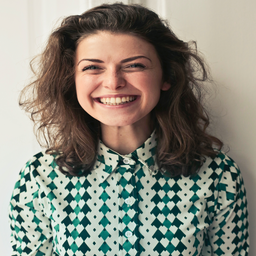

In [3]:
#Loading image
import PIL
from PIL import Image
from IPython.display import display
import numpy as np

im_width, im_height = 300,300
load_im = PIL.Image.open("pexels_andrea.jpg")
target_width = 256
target_height= 256

#Crop image to 256 x 256
width,height = load_im.size
crop_image = load_im.crop((0, (height-width)/2, width, height))
crop_image = crop_image.resize((target_width, target_height), Image.LANCZOS)

display(crop_image)
image_array = np.asarray(crop_image)


In [4]:
masks = mask_generator.generate(image_array)

In [5]:
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

Number of masks generated: 70
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


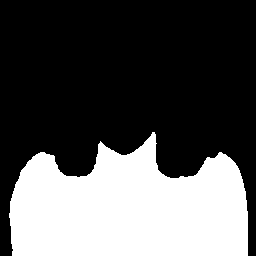

In [9]:
# Decide which mask you want to do inpainting with.
mask_index = 2

segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [10]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["t-shirt",  "red flowers shirt", "a zebra shirt"]

generator = torch.Generator().manual_seed(77) # 155, 77, 

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for prompt in inpainting_prompts:
        image = pipe(prompt=prompt, image=crop_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
import copy
import matplotlib.pyplot as plt 
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image

        # Add the image to the grid
        axes[idx].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[idx].set_title(name)

        # Turn off axes for the subplot
        axes[idx].axis('off')
        

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


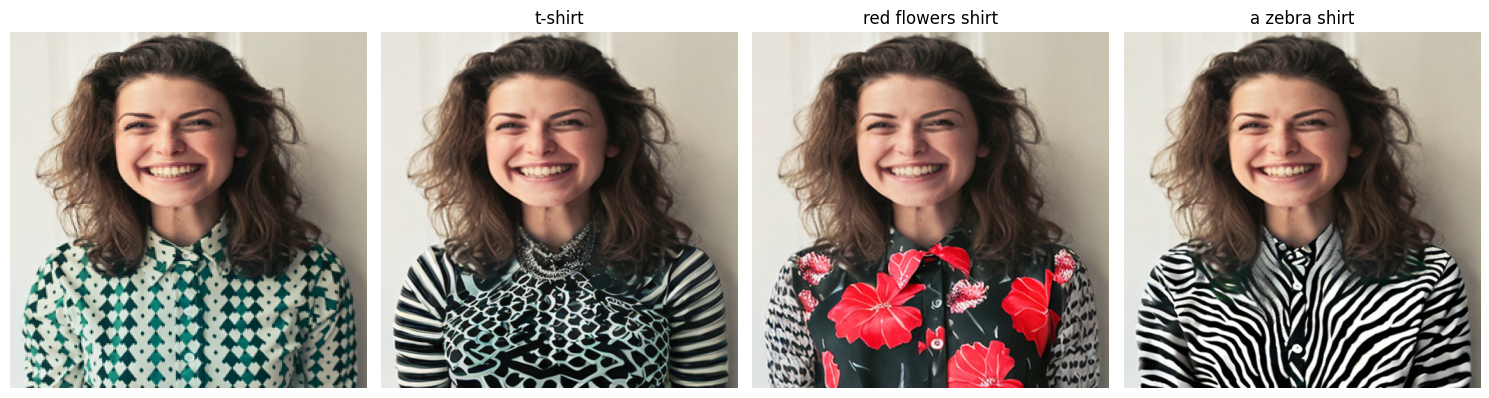

In [16]:
create_image_grid(crop_image, encoded_images, inpainting_prompts, 1, 4)